#**PACOTES**


In [ ]:
import sqlite3

In [ ]:
import polars as pl

In [ ]:
!pip install plotnine
from plotnine import *

#**LEITURA DOS DADOS**

In [ ]:
path = '/content/drive/MyDrive/dadosas_anos.db' #banco de dados contendo as estacoes, datas, anos e precipitacao

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
conn = sqlite3.connect(path)

In [ ]:
local = pl.read_csv("/content/CatalogoEstaçõesAutomáticas.csv", separator = ";" ) #banco de dados contendo as estacoes  e os estados respectivos

In [ ]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tabelas = cursor.fetchall()

# Exibir as tabelas
print("Tabelas no banco de dados:", tabelas)

Tabelas no banco de dados: [('dados_2000',), ('dados_2001',), ('dados_2002',), ('dados_2003',), ('dados_2004',), ('dados_2005',), ('dados_2006',), ('dados_2007',), ('dados_2008',), ('dados_2009',), ('dados_2010',), ('dados_2011',), ('dados_2012',), ('dados_2013',), ('dados_2014',), ('dados_2015',), ('dados_2016',), ('dados_2017',), ('dados_2018',), ('dados_2019',), ('dados_2020',), ('dados_2021',), ('dados_2022',), ('dados_2023',), ('dados_2024',)]


#**DADOS EL NIÑO**


In [ ]:
nino_jun_dez = pl.read_database("""SELECT `data`, `PRECIPITAÇÃO TOTAL, HORÁRIO (mm)`, `estacao` FROM dados_2023""", conn, infer_schema_length=10000)
nino_jan_abril = pl.read_database("""SELECT `data`, `PRECIPITAÇÃO TOTAL, HORÁRIO (mm)`, `estacao` FROM dados_2024""", conn, infer_schema_length=10000)

nino_jun_dez = nino_jun_dez.with_columns(
    pl.col("data").str.strptime(pl.Date, "%Y/%m/%d", strict=False).alias("data")
).filter(
    (pl.col("data").dt.month() >= 6)
    ).join(local, left_on="estacao", right_on="CD_ESTACAO", how="full"
    ).select(
    pl.col("data"),
    pl.col("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"),
    pl.col("SG_ESTADO")
).filter(pl.col("data").is_not_null()).filter(pl.col("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)").is_not_null())

nino_jan_abril = nino_jan_abril.with_columns(
    pl.col("data").str.strptime(pl.Date, "%Y/%m/%d", strict=False).alias("data")
).filter(
    (pl.col("data").dt.month() <= 4)
    ).join(local, left_on="estacao", right_on="CD_ESTACAO", how="full"
    ).select(
    pl.col("data"),
    pl.col("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"),
    pl.col("SG_ESTADO")
).filter(pl.col("data").is_not_null()).filter(pl.col("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)").is_not_null())


In [ ]:
regioes = {
    "SUL": ["PR", "SC", "RS"],
    "SUDESTE": ["SP", "RJ", "MG", "ES"],
    "CENTRO-OESTE": ["DF", "GO", "MT", "MS"],
    "NORDESTE": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
    "NORTE": ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
}

teste1 = nino_jun_dez.with_columns(
    mes = pl.col("data").dt.month(),
    ano = pl.col("data").dt.year()
).with_columns(
      regiao =
      pl.when(pl.col("SG_ESTADO").is_in(regioes["SUL"])).then(pl.lit("SUL"))
      .when(pl.col("SG_ESTADO").is_in(regioes["NORDESTE"])).then(pl.lit("NORDESTE"))
      .when(pl.col("SG_ESTADO").is_in(regioes["NORTE"])).then(pl.lit("NORTE"))
  ).filter(pl.col("regiao").is_not_null()
  ).group_by("mes","ano", "regiao").agg(
    pl.col("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)").sum().alias("PRECIPITACAO TOTAL")
  )

teste2 = nino_jan_abril.with_columns(
    mes = pl.col("data").dt.month(),
    ano = pl.col("data").dt.year()
).with_columns(pl.col("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)").cast(pl.Float64),
      regiao =
      pl.when(pl.col("SG_ESTADO").is_in(regioes["SUL"])).then(pl.lit("SUL"))
      .when(pl.col("SG_ESTADO").is_in(regioes["NORDESTE"])).then(pl.lit("NORDESTE"))
      .when(pl.col("SG_ESTADO").is_in(regioes["NORTE"])).then(pl.lit("NORTE"))
  ).filter(pl.col("regiao").is_not_null()
  ).group_by("mes", "ano", "regiao").agg(
    pl.col("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)").sum().alias("PRECIPITACAO TOTAL")
  )


dados_nino = pl.concat([teste1, teste2])



dados_nino = dados_nino.with_columns(
    pl.when(pl.col("mes") == 6).then(1)
    .when(pl.col("mes") == 7).then(2)
    .when(pl.col("mes") == 8).then(3)
    .when(pl.col("mes") == 9).then(4)
    .when(pl.col("mes") == 10).then(5)
    .when(pl.col("mes") == 11).then(6)
    .when(pl.col("mes") == 12).then(7)
    .when(pl.col("mes") == 1).then(8)
    .when(pl.col("mes") == 2).then(9)
    .when(pl.col("mes") == 3).then(10)
    .when(pl.col("mes") == 4).then(11)
)

dados_nino.sort("ordem_mes")

mes,ano,regiao,PRECIPITACAO TOTAL,ordem_mes,literal
i8,i32,str,f64,i32,i32
6,2023,"""NORTE""",3803.4,1,1
6,2023,"""SUL""",9873.4,1,1
6,2023,"""NORDESTE""",5670.0,1,1
7,2023,"""SUL""",12258.0,2,2
7,2023,"""NORDESTE""",3200.8,2,2
…,…,…,…,…,…
3,2024,"""NORDESTE""",13744.8,10,10
3,2024,"""NORTE""",19161.6,10,10
4,2024,"""SUL""",18994.8,11,11


**Método para a análise:**

Vamos comparar as médias de precipitações nos anos anteriores do El Niño com os anos em que ele prevaleceu. Para isso, usaremos 2 gráficos.

**1)** Grafico do El Nino

  - Fazer um gráfico de barras, onde o eixo x são os meses de prevalência do El Niño (jun/23 a abril/24) e o eixo Y é a precipitação total do mês

**2)** Grafico dos anos anteriores
  - Fazer um gráfico de barras, onde o eixo x representa os meses (jun a abril) e o eixo Y é a precipitação média daquele mês


Para o segundo gráfico, teremos que:

- ler os dados de **OUTUBRO/2016 - MAIO/2023** com as colunas `data`, `PRECIPITAÇÃO TOTAL, HORÁRIO (mm)`, `estacao`
- criar uma nova coluna identificando o mês de cada dado
- fazer, para cada arquivo do ano, o **total** de precipitações em cada mês
- juntar todos os anos, e fazer a média do total de precipitações
- plotar o gráfico



#**GRÁFICO EL NIÑO**

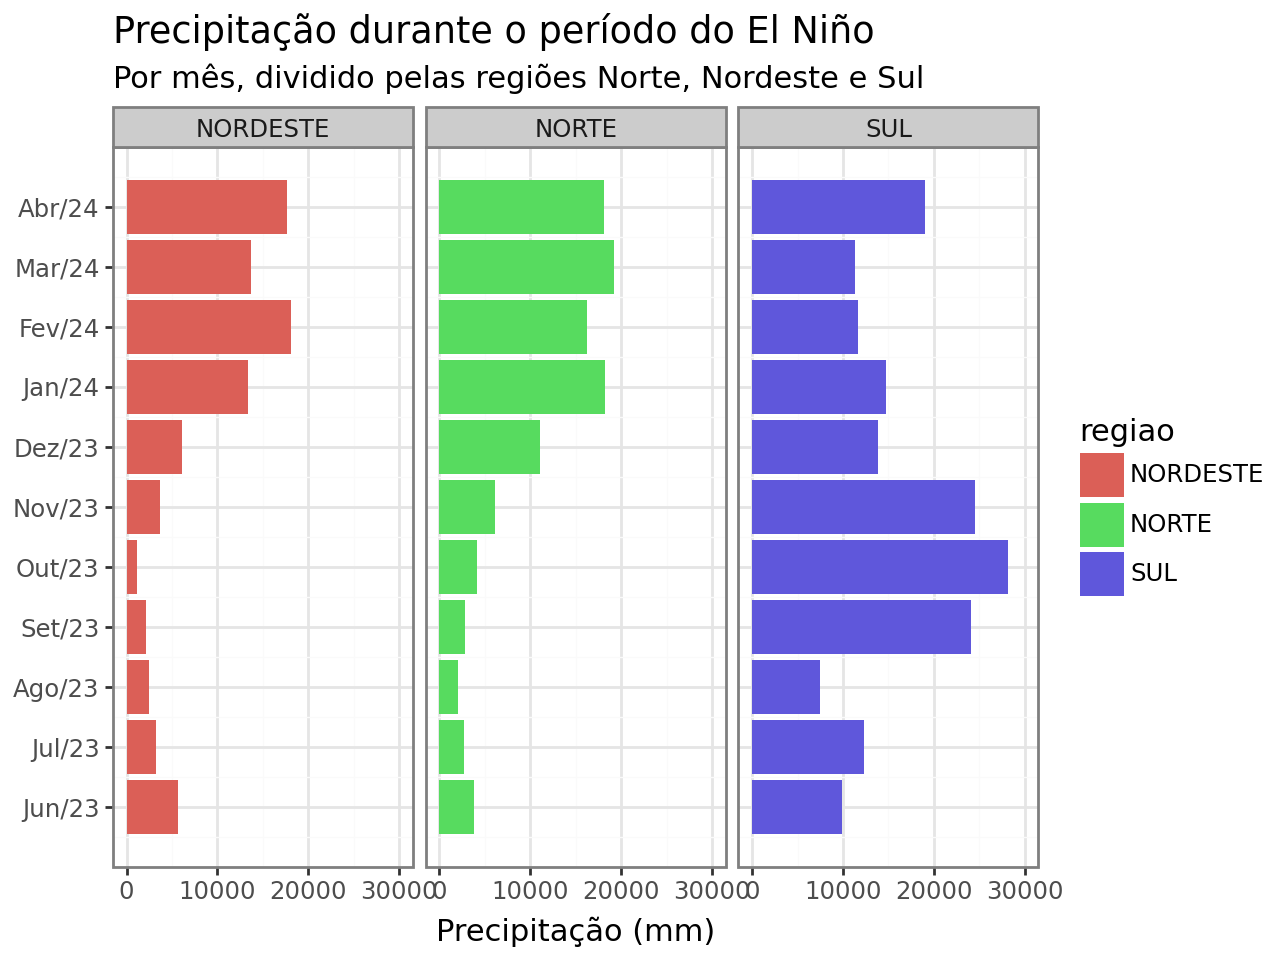

In [ ]:
grafico_nino = ggplot(dados_nino
          ) + geom_col(aes(
              x = "ordem_mes",
              y = "PRECIPITACAO TOTAL",
              fill = "regiao"
          )) + scale_x_continuous(
              labels = ["Jun/23", "Jul/23", "Ago/23", "Set/23", "Out/23",
                        "Nov/23", "Dez/23", "Jan/24", "Fev/24", "Mar/24", "Abr/24"],
              breaks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
          ) + scale_y_continuous(
              limits = [0, 30000]
          ) + facet_wrap("regiao") + coord_flip(
          ) + labs(title = "Precipitação durante o período do El Niño",
                   subtitle = "Por mês, dividido pelas regiões Norte, Nordeste e Sul",
                   y = "Precipitação (mm)", x = ""
          ) + theme(legend_position = 'none'
          ) + theme_bw()



grafico_nino




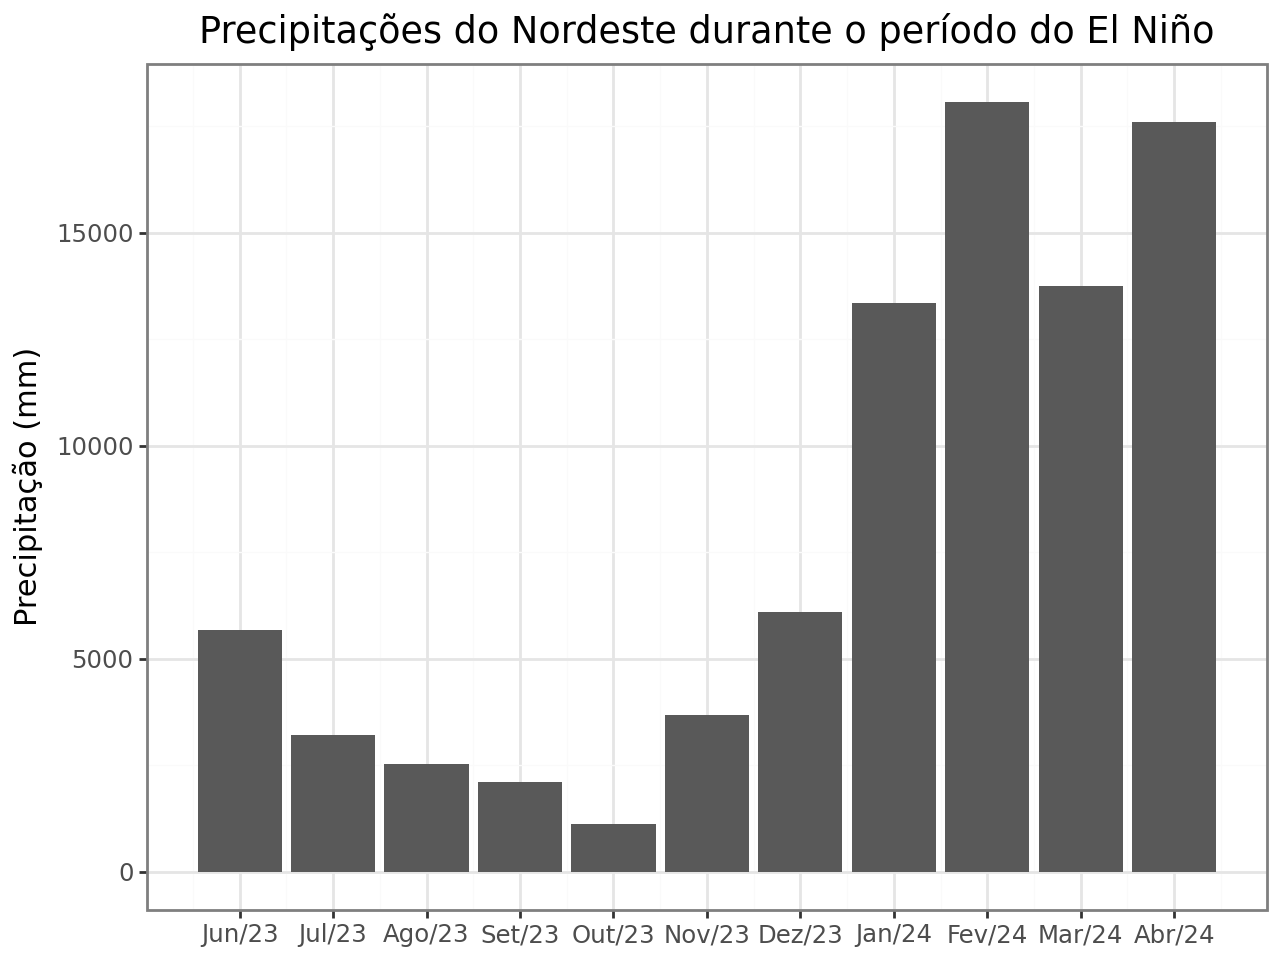

In [ ]:
nordeste = dados_nino.filter(pl.col("regiao") == "NORDESTE")
nordeste

grafico_nino_ne = ggplot(nordeste
          ) + geom_col(aes(
              x = "ordem_mes",
              y = "PRECIPITACAO TOTAL"
          )) + scale_x_continuous(
              labels = ["Jun/23", "Jul/23", "Ago/23", "Set/23", "Out/23",
                        "Nov/23", "Dez/23", "Jan/24", "Fev/24", "Mar/24", "Abr/24"],
              breaks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
          ) + labs(title = "Precipitações do Nordeste durante o período do El Niño",
                   y = "Precipitação (mm)", x = ""
          ) + theme(legend_position = 'none'
          ) + theme_bw()



grafico_nino_ne


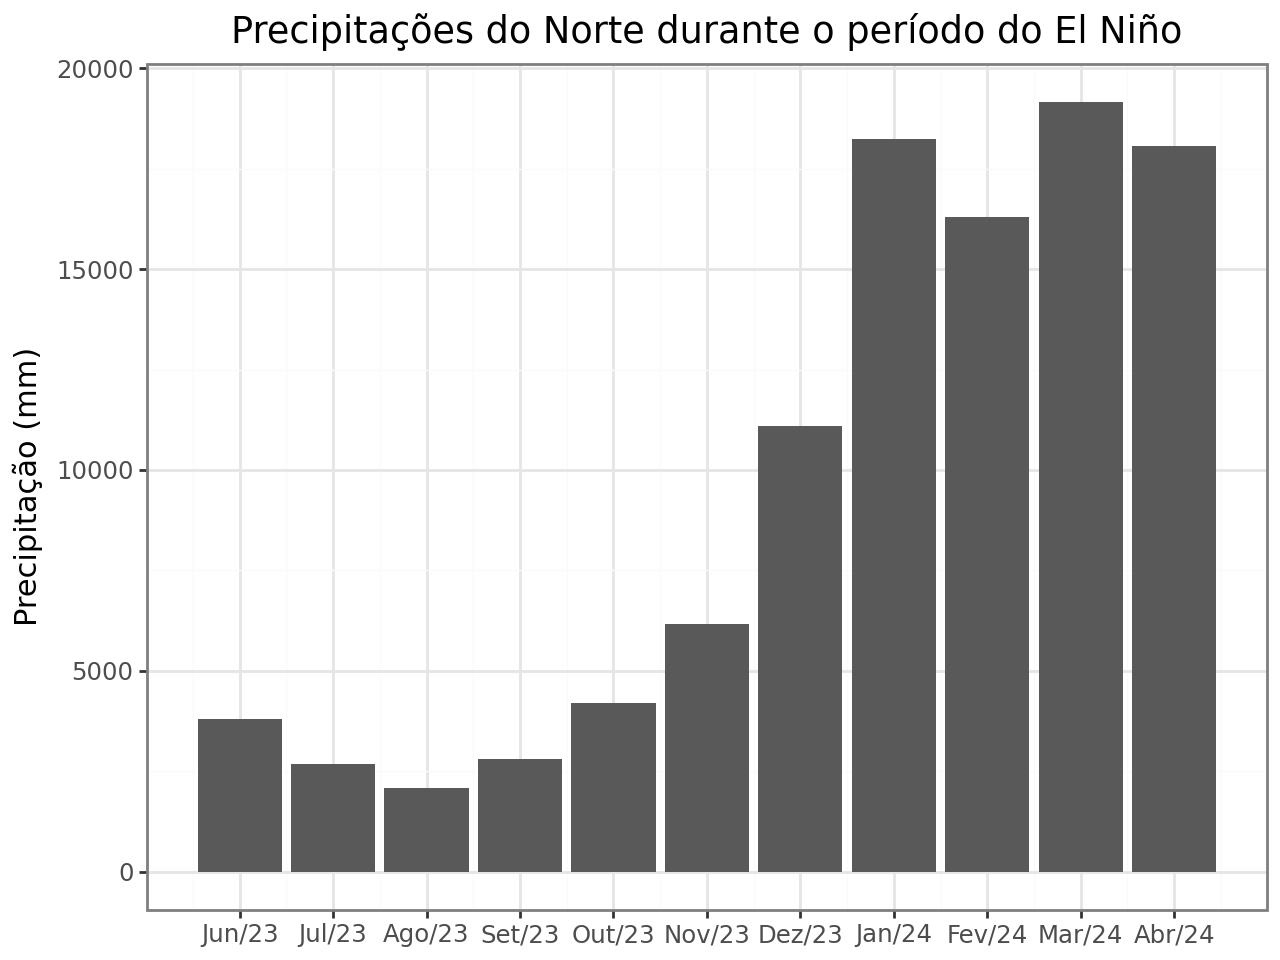

In [ ]:
norte = dados_nino.filter(pl.col("regiao") == "NORTE")
norte

grafico_nino_nor = ggplot(norte
          ) + geom_col(aes(
              x = "ordem_mes",
              y = "PRECIPITACAO TOTAL"
          )) + scale_x_continuous(
              labels = ["Jun/23", "Jul/23", "Ago/23", "Set/23", "Out/23",
                        "Nov/23", "Dez/23", "Jan/24", "Fev/24", "Mar/24", "Abr/24"],
              breaks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
          ) + labs(title = "Precipitações do Norte durante o período do El Niño",
                   y = "Precipitação (mm)", x = ""
          ) + theme(legend_position = 'none'
          ) + theme_bw()



grafico_nino_nor

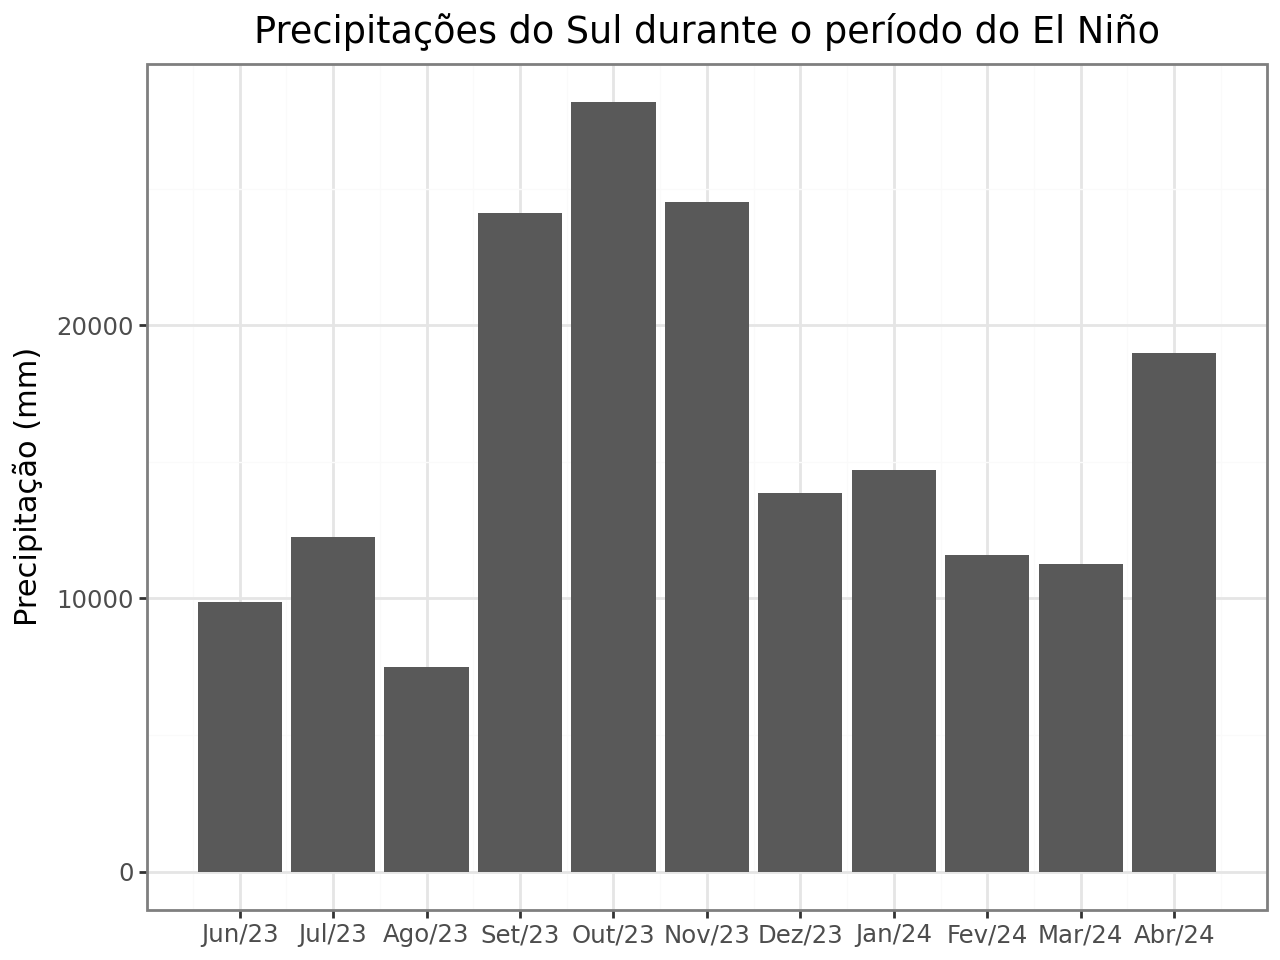

In [ ]:
sul = dados_nino.filter(pl.col("regiao") == "SUL")
sul

grafico_nino_s = ggplot(sul
          ) + geom_col(aes(
              x = "ordem_mes",
              y = "PRECIPITACAO TOTAL"
          )) + scale_x_continuous(
              labels = ["Jun/23", "Jul/23", "Ago/23", "Set/23", "Out/23",
                        "Nov/23", "Dez/23", "Jan/24", "Fev/24", "Mar/24", "Abr/24"],
              breaks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
          ) + labs(title = "Precipitações do Sul durante o período do El Niño",
                   y = "Precipitação (mm)", x = ""
          ) + theme(legend_position = 'none'
          ) + theme_bw()



grafico_nino_s

#**Analise de outubro de 2016 à março de 2023**
conectando com o banco de dados

In [ ]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tabelas = cursor.fetchall()

# Exibir as tabelas
print("Tabelas no banco de dados:", tabelas)

In [ ]:
query_16 = """SELECT data, COALESCE("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)", 0.0) AS "PRECIPITACAO", estacao FROM dados_2016;"""
query_17 =  """SELECT data, COALESCE("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)", 0.0) AS "PRECIPITACAO", estacao FROM dados_2017"""
query_18 = """SELECT data,COALESCE("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)", 0.0) AS "PRECIPITACAO", estacao FROM dados_2018"""
query_19 = """SELECT data, COALESCE("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)", 0.0) AS "PRECIPITACAO", estacao FROM dados_2019"""
query_20 = """SELECT data, COALESCE("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)", 0.0) AS "PRECIPITACAO", estacao FROM dados_2020"""
query_21 = """SELECT data, COALESCE("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)", 0.0) AS "PRECIPITACAO", estacao FROM dados_2021"""
query_22 = """SELECT data, COALESCE("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)", 0.0) AS "PRECIPITACAO", estacao FROM dados_2022"""
query_23 = """SELECT data, COALESCE("PRECIPITAÇÃO TOTAL, HORÁRIO (mm)", 0.0) AS "PRECIPITACAO", estacao FROM dados_2023"""

In [ ]:
dados_16 = pl.read_database(query_16, conn)

In [ ]:
dados_17 = pl.read_database(query_17, conn)

In [ ]:
dados_18 = pl.read_database(query_18, conn)
dados_19 = pl.read_database(query_19, conn)
dados_20 = pl.read_database(query_20, conn)
dados_21 = pl.read_database(query_21, conn)
dados_22 = pl.read_database(query_22, conn)
dados_23 = pl.read_database(query_23, conn)
dados_23.head()

In [ ]:
#Nomeando as regioes para facilitar as analises
regioes = {
    "SUL": ["PR", "SC", "RS"],
    "SUDESTE": ["SP", "RJ", "MG", "ES"],
    "CENTRO-OESTE": ["DF", "GO", "MT", "MS"],
    "NORDESTE": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
    "NORTE": ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
}

#**Organizando os dados para cada ano**

In [ ]:
dados_16 = dados_16.join(local, left_on='estacao', right_on='CD_ESTACAO', how='inner').with_columns(pl.col("data").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("data"))

dados_16 = dados_16.filter((pl.col("data").dt.month() >= 10)).select(
    pl.col("data"),
    pl.col("PRECIPITACAO"),
    pl.col("SG_ESTADO")).filter(pl.col("data").is_not_null()).filter(pl.col("PRECIPITACAO").is_not_null())

dados_16_outubro = dados_16.with_columns(
    mes = pl.col("data").dt.month()
).with_columns(
      regiao =
      pl.when(pl.col("SG_ESTADO").is_in(regioes["SUL"])).then(pl.lit("SUL"))
      .when(pl.col("SG_ESTADO").is_in(regioes["NORDESTE"])).then(pl.lit("NORDESTE"))
      .when(pl.col("SG_ESTADO").is_in(regioes["NORTE"])).then(pl.lit("NORTE"))
  ).filter(pl.col("regiao").is_not_null()
  ).group_by("mes","regiao").agg(
    pl.col("PRECIPITACAO").sum().alias("PRECIPITACAO_TOTAL")
  )


In [ ]:
#----------------------2017--------------------------------------------
dados_17_fn = (
    dados_17
    .join(local, left_on='estacao', right_on='CD_ESTACAO', how='inner')  # Join com local
    .with_columns(pl.col("data").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("data"))
    .with_columns(pl.col("data").dt.month().alias("mes") )
    .filter(
        pl.col("data").is_not_null() &  # Garante que a data não é nula
        pl.col("PRECIPITACAO").is_not_null()  # Garante que a precipitação não é nula
    )
    .with_columns(
        pl.when(pl.col("SG_ESTADO").is_in(regioes["SUL"])).then(pl.lit("SUL"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORDESTE"])).then(pl.lit("NORDESTE"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORTE"])).then(pl.lit("NORTE"))
        .otherwise(None).alias("regiao")  # Mapeia os estados para as regiões
    )
    .filter(pl.col("regiao").is_not_null())  # Filtra para garantir que a região não seja nula
    .group_by(["mes", "regiao"])
    .agg(
        pl.col("PRECIPITACAO").sum().alias("PRECIPITACAO_TOTAL")  # Soma a precipitação
    )
      .sort("mes")
)

dados_17_fn


mes,regiao,PRECIPITACAO_TOTAL
i8,str,f64
1,"""SUL""",14732.2
1,"""NORDESTE""",6239.6
1,"""NORTE""",18040.4
2,"""NORDESTE""",12570.4
2,"""NORTE""",22426.8
…,…,…
11,"""SUL""",12499.8
11,"""NORTE""",10034.4
12,"""SUL""",13299.4


In [ ]:
#------------------------2018--------------------------------
dados_18_fn = (
    dados_18
    .join(local, left_on='estacao', right_on='CD_ESTACAO', how='inner')  # Join com local
    .with_columns(pl.col("data").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("data"))
    .with_columns(pl.col("data").dt.month().alias("mes") )
    .filter(
        pl.col("data").is_not_null() &  # Garante que a data não é nula
        pl.col("PRECIPITACAO").is_not_null()  # Garante que a precipitação não é nula
    )
    .with_columns(
        pl.when(pl.col("SG_ESTADO").is_in(regioes["SUL"])).then(pl.lit("SUL"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORDESTE"])).then(pl.lit("NORDESTE"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORTE"])).then(pl.lit("NORTE"))
        .otherwise(None).alias("regiao")  # Mapeia os estados para as regiões
    )
    .filter(pl.col("regiao").is_not_null())  # Filtra para garantir que a região não seja nula
    .group_by(["mes", "regiao"])
    .agg(
        pl.col("PRECIPITACAO").sum().alias("PRECIPITACAO_TOTAL")  # Soma a precipitação
    )
      .sort("mes")
)
dados_18_fn

mes,regiao,PRECIPITACAO_TOTAL
i8,str,f64
1,"""NORDESTE""",8782.6
1,"""NORTE""",14429.4
1,"""SUL""",17346.8
2,"""NORDESTE""",17567.6
2,"""NORTE""",20736.2
…,…,…
11,"""NORTE""",13822.4
11,"""NORDESTE""",8102.6
12,"""NORTE""",16700.6


In [ ]:
#----------------2019-----------------------------------------
dados_19_fn = (
    dados_19
    .join(local, left_on='estacao', right_on='CD_ESTACAO', how='inner')  # Join com local
    .with_columns(pl.col("data").str.strptime(pl.Date, "%Y/%m/%d", strict=False).alias("data"))
    .with_columns(pl.col("data").dt.month().alias("mes") )
    .filter(
        pl.col("data").is_not_null() &  # Garante que a data não é nula
        pl.col("PRECIPITACAO").is_not_null()  # Garante que a precipitação não é nula
    )
    .with_columns(
        pl.when(pl.col("SG_ESTADO").is_in(regioes["SUL"])).then(pl.lit("SUL"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORDESTE"])).then(pl.lit("NORDESTE"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORTE"])).then(pl.lit("NORTE"))
        .otherwise(None).alias("regiao")  # Mapeia os estados para as regiões
    )
    .filter(pl.col("regiao").is_not_null())  # Filtra para garantir que a região não seja nula
    .group_by(["mes", "regiao"])
    .agg(
        pl.col("PRECIPITACAO").sum().alias("PRECIPITACAO_TOTAL")  # Soma a precipitação
    )
      .sort("mes")
)
dados_19_fn

mes,regiao,PRECIPITACAO_TOTAL
i8,str,f64
1,"""NORDESTE""",7109.6
1,"""SUL""",18448.0
1,"""NORTE""",16447.8
2,"""NORDESTE""",11452.8
2,"""NORTE""",18129.6
…,…,…
11,"""NORDESTE""",3531.2
11,"""SUL""",12193.2
12,"""NORDESTE""",4797.4


In [ ]:
#----------------2020--------------------------------------------------
dados_20_fn = (
    dados_20
    .join(local, left_on='estacao', right_on='CD_ESTACAO', how='inner')  # Join com local
    .with_columns(pl.col("data").str.strptime(pl.Date, "%Y/%m/%d", strict=False).alias("data"))
    .with_columns(pl.col("data").dt.month().alias("mes") )
    .filter(
        pl.col("data").is_not_null() &  # Garante que a data não é nula
        pl.col("PRECIPITACAO").is_not_null()  # Garante que a precipitação não é nula
    )
    .with_columns(
        pl.when(pl.col("SG_ESTADO").is_in(regioes["SUL"])).then(pl.lit("SUL"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORDESTE"])).then(pl.lit("NORDESTE"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORTE"])).then(pl.lit("NORTE"))
        .otherwise(None).alias("regiao")  # Mapeia os estados para as regiões
    )
    .filter(pl.col("regiao").is_not_null())  # Filtra para garantir que a região não seja nula
    .group_by(["mes", "regiao"])
    .agg(
        pl.col("PRECIPITACAO").sum().alias("PRECIPITACAO_TOTAL")  # Soma a precipitação
    )
      .sort("mes")
)


#-------------------2021---------------------------------------------------------
dados_21_fn = (
    dados_21
    .join(local, left_on='estacao', right_on='CD_ESTACAO', how='inner')  # Join com local
    .with_columns(pl.col("data").str.strptime(pl.Date, "%Y/%m/%d", strict=False).alias("data"))
    .with_columns(pl.col("data").dt.month().alias("mes") )
    .filter(
        pl.col("data").is_not_null() &  # Garante que a data não é nula
        pl.col("PRECIPITACAO").is_not_null()  # Garante que a precipitação não é nula
    )
    .with_columns(
        pl.when(pl.col("SG_ESTADO").is_in(regioes["SUL"])).then(pl.lit("SUL"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORDESTE"])).then(pl.lit("NORDESTE"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORTE"])).then(pl.lit("NORTE"))
        .otherwise(None).alias("regiao")  # Mapeia os estados para as regiões
    )
    .filter(pl.col("regiao").is_not_null())  # Filtra para garantir que a região não seja nula
    .group_by(["mes", "regiao"])
    .agg(
        pl.col("PRECIPITACAO").sum().alias("PRECIPITACAO_TOTAL")  # Soma a precipitação
    )
      .sort("mes")
)


#-----------------2022-------------------------------------------------------------
dados_22_fn = (
    dados_22
    .join(local, left_on='estacao', right_on='CD_ESTACAO', how='inner')  # Join com local
    .with_columns(pl.col("data").str.strptime(pl.Date, "%Y/%m/%d", strict=False).alias("data"))
    .with_columns(pl.col("data").dt.month().alias("mes") )
    .filter(
        pl.col("data").is_not_null() &  # Garante que a data não é nula
        pl.col("PRECIPITACAO").is_not_null()  # Garante que a precipitação não é nula
    )
    .with_columns(
        pl.when(pl.col("SG_ESTADO").is_in(regioes["SUL"])).then(pl.lit("SUL"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORDESTE"])).then(pl.lit("NORDESTE"))
        .when(pl.col("SG_ESTADO").is_in(regioes["NORTE"])).then(pl.lit("NORTE"))
        .otherwise(None).alias("regiao")  # Mapeia os estados para as regiões
    )
    .filter(pl.col("regiao").is_not_null())  # Filtra para garantir que a região não seja nula
    .group_by(["mes", "regiao"])
    .agg(
        pl.col("PRECIPITACAO").sum().alias("PRECIPITACAO_TOTAL")  # Soma a precipitação
    )
      .sort("mes")
)


#-----------------2023--------------------------------------------------------------------
dados_23 = dados_23.join(local, left_on='estacao', right_on='CD_ESTACAO', how='inner').with_columns(pl.col("data").str.strptime(pl.Date, "%Y/%m/%d", strict=False).alias("data"))
#agora vou pegar só as partes que preciso de 2023 (até maio)
dados_23 = dados_23.filter((pl.col("data").dt.month() <= 4 )).select(
    pl.col("data"),
    pl.col("PRECIPITACAO"),
    pl.col("SG_ESTADO")).filter(pl.col("data").is_not_null()).filter(pl.col("PRECIPITACAO").is_not_null())

dados_23_fim_abril = dados_23.with_columns(
    mes = pl.col("data").dt.month()
).with_columns(
      regiao =
      pl.when(pl.col("SG_ESTADO").is_in(regioes["SUL"])).then(pl.lit("SUL"))
      .when(pl.col("SG_ESTADO").is_in(regioes["NORDESTE"])).then(pl.lit("NORDESTE"))
      .when(pl.col("SG_ESTADO").is_in(regioes["NORTE"])).then(pl.lit("NORTE"))
  ).filter(pl.col("regiao").is_not_null()
  ).group_by("mes","regiao").agg(
    pl.col("PRECIPITACAO").sum().alias("PRECIPITACAO_TOTAL")
  )

#**Montando o grafico do ano sem EL NIÑO**

In [ ]:
#vamos juntar todos os data frames que criamos, pra isso vou fazer uma lista e depois concatenar
anos_sem_nino = [dados_16_outubro, dados_17_fn, dados_18_fn, dados_19_fn, dados_20_fn, dados_21_fn, dados_22_fn, dados_23_fim_abril]
dados_completos = pl.concat(anos_sem_nino)



In [ ]:
#agora que eu juntei todos os dados, eu vou calcular a media de precipitacao para poder criar uma nova tabela usando apenas os meses e a precipitacao
dados_precipitacao = (
    dados_completos
    .group_by(["mes", "regiao"])  # Agrupar por mês e região
    .agg(
        pl.col("PRECIPITACAO_TOTAL").mean().round(2).alias("media_precipitacao")  # Calcular a média da precipitação
    )
)

dados_precipitacao = dados_precipitacao.with_columns(
    pl.when(pl.col("mes") == 6).then(1)
    .when(pl.col("mes") == 7).then(2)
    .when(pl.col("mes") == 8).then(3)
    .when(pl.col("mes") == 9).then(4)
    .when(pl.col("mes") == 10).then(5)
    .when(pl.col("mes") == 11).then(6)
    .when(pl.col("mes") == 12).then(7)
    .when(pl.col("mes") == 1).then(8)
    .when(pl.col("mes") == 2).then(9)
    .when(pl.col("mes") == 3).then(10)
    .when(pl.col("mes") == 4).then(11)
    .otherwise(12).alias("ordem_mes")
).filter(pl.col("mes") != 5)


mes,regiao,media_precipitacao,ordem_mes
i8,str,f64,i32
10,"""SUL""",14407.86,5
3,"""SUL""",10625.51,10
12,"""NORDESTE""",8189.94,7
8,"""NORTE""",2221.93,3
6,"""NORDESTE""",5498.73,1
…,…,…,…
10,"""NORDESTE""",3221.49,5
10,"""NORTE""",5791.86,5
8,"""NORDESTE""",2753.07,3


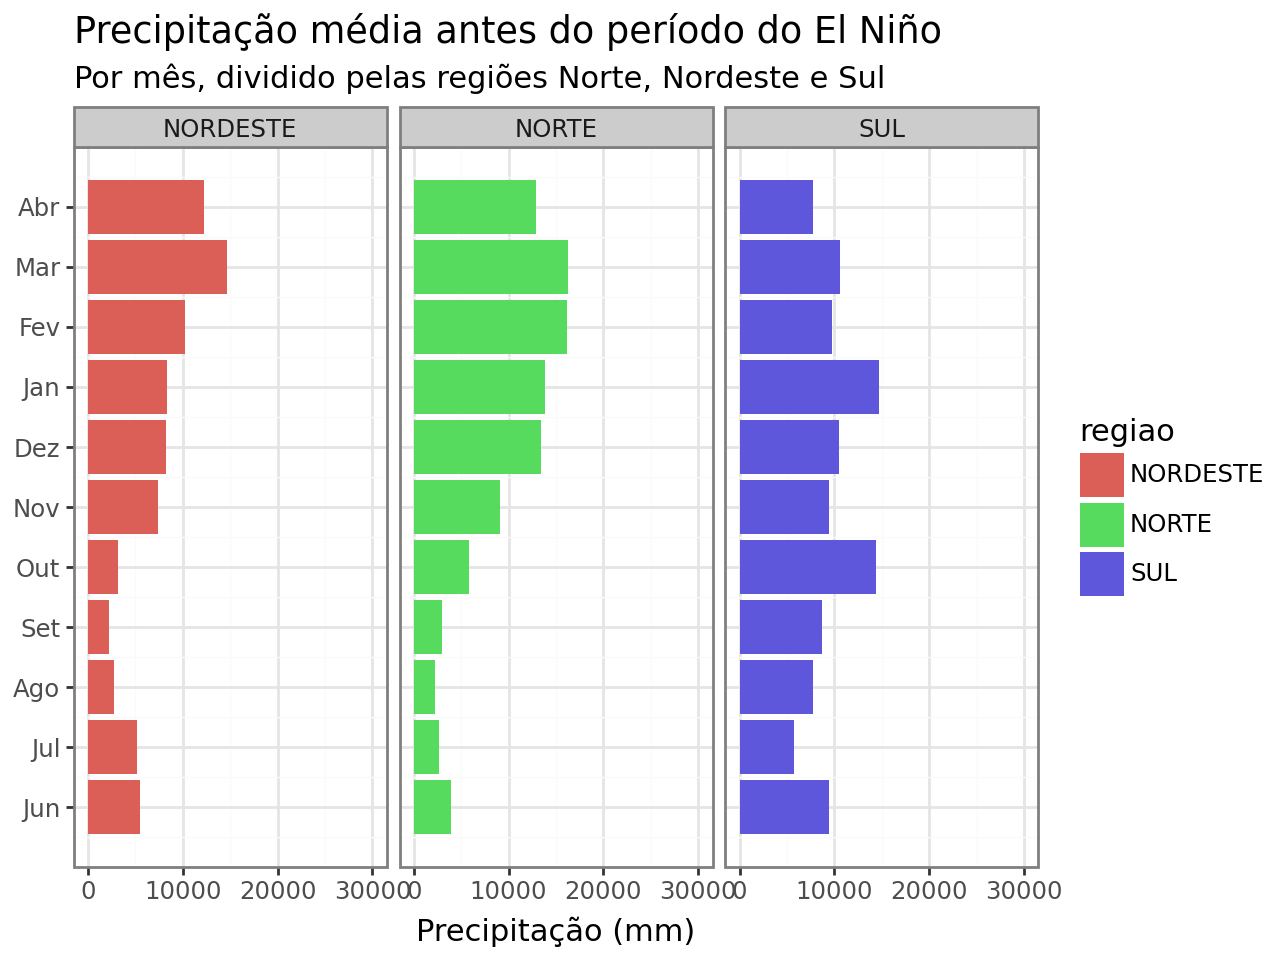

In [ ]:
#plotando o grafico
grafico_sem_nino = ggplot(dados_precipitacao
          ) + geom_col(aes(
              x = "ordem_mes",
              y = "media_precipitacao",
              fill = "regiao"
          )) + scale_x_continuous(
              labels = ["Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez",
                        "Jan", "Fev", "Mar", "Abr", "Mai"],
              breaks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
          ) + scale_y_continuous(
              limits = [0, 30000]
          ) + facet_wrap("regiao") + coord_flip(
          ) + labs(title = "Precipitação média antes do período do El Niño",
                   subtitle = "Por mês, dividido pelas regiões Norte, Nordeste e Sul",
                   y = "Precipitação (mm)", x = ""
          ) + theme(legend_position = 'none'
          ) +theme_bw()



grafico_sem_nino

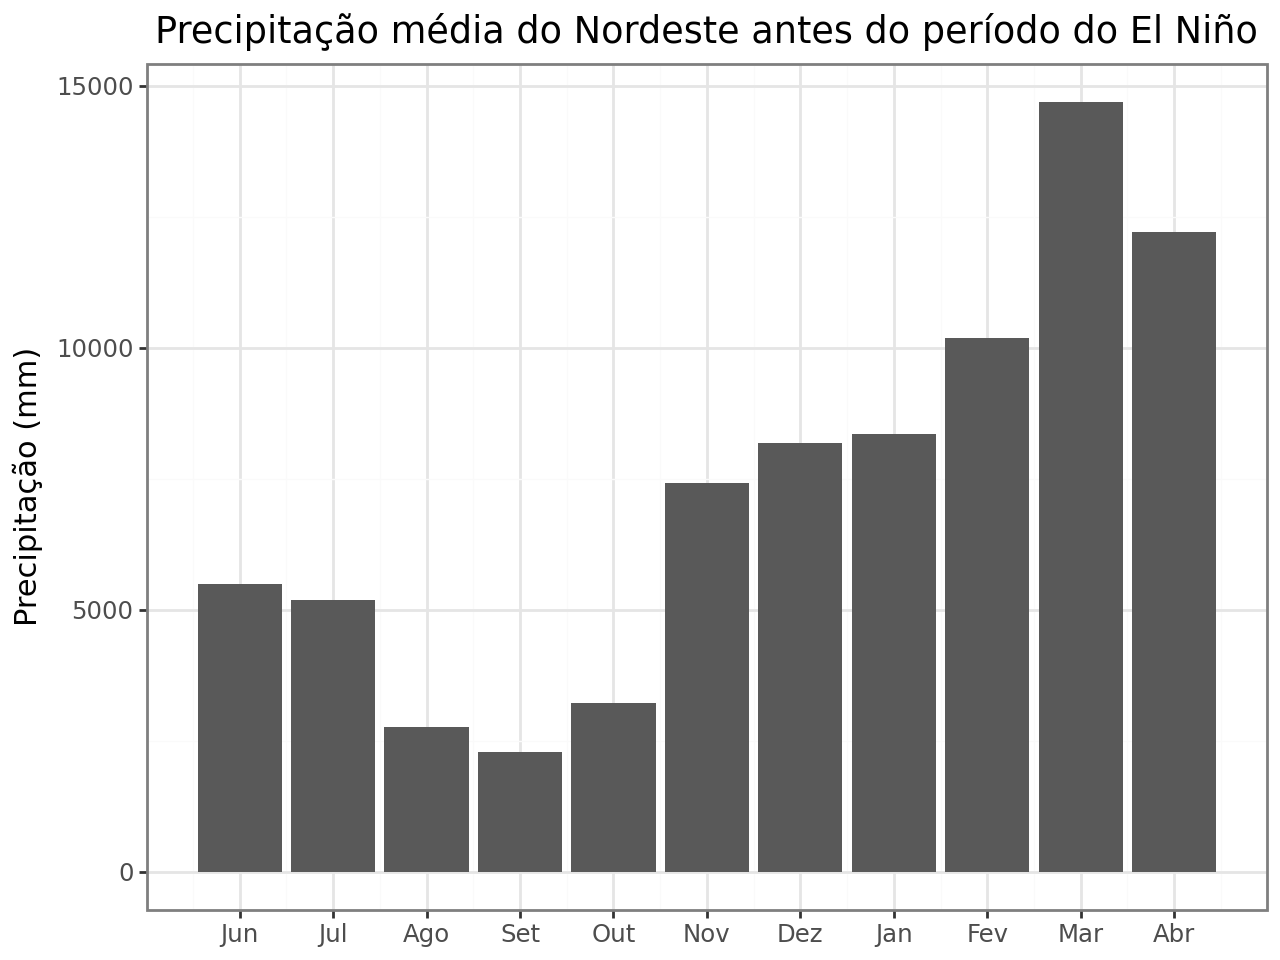

In [ ]:
# gráfico só do nordeste antes do el nino:
nordeste = dados_precipitacao.filter(pl.col("regiao") == "NORDESTE")
nordeste_sem_nino = ggplot(nordeste
          ) + geom_col(aes(
              x = "ordem_mes",
              y = "media_precipitacao"
          )) + scale_x_continuous(
              labels = ["Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez",
                        "Jan", "Fev", "Mar", "Abr", "Mai"],
              breaks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
          ) + labs(title = "Precipitação média do Nordeste antes do período do El Niño",
                   y = "Precipitação (mm)", x = ""
          ) + theme(legend_position = 'none'
          ) + theme_bw()



nordeste_sem_nino

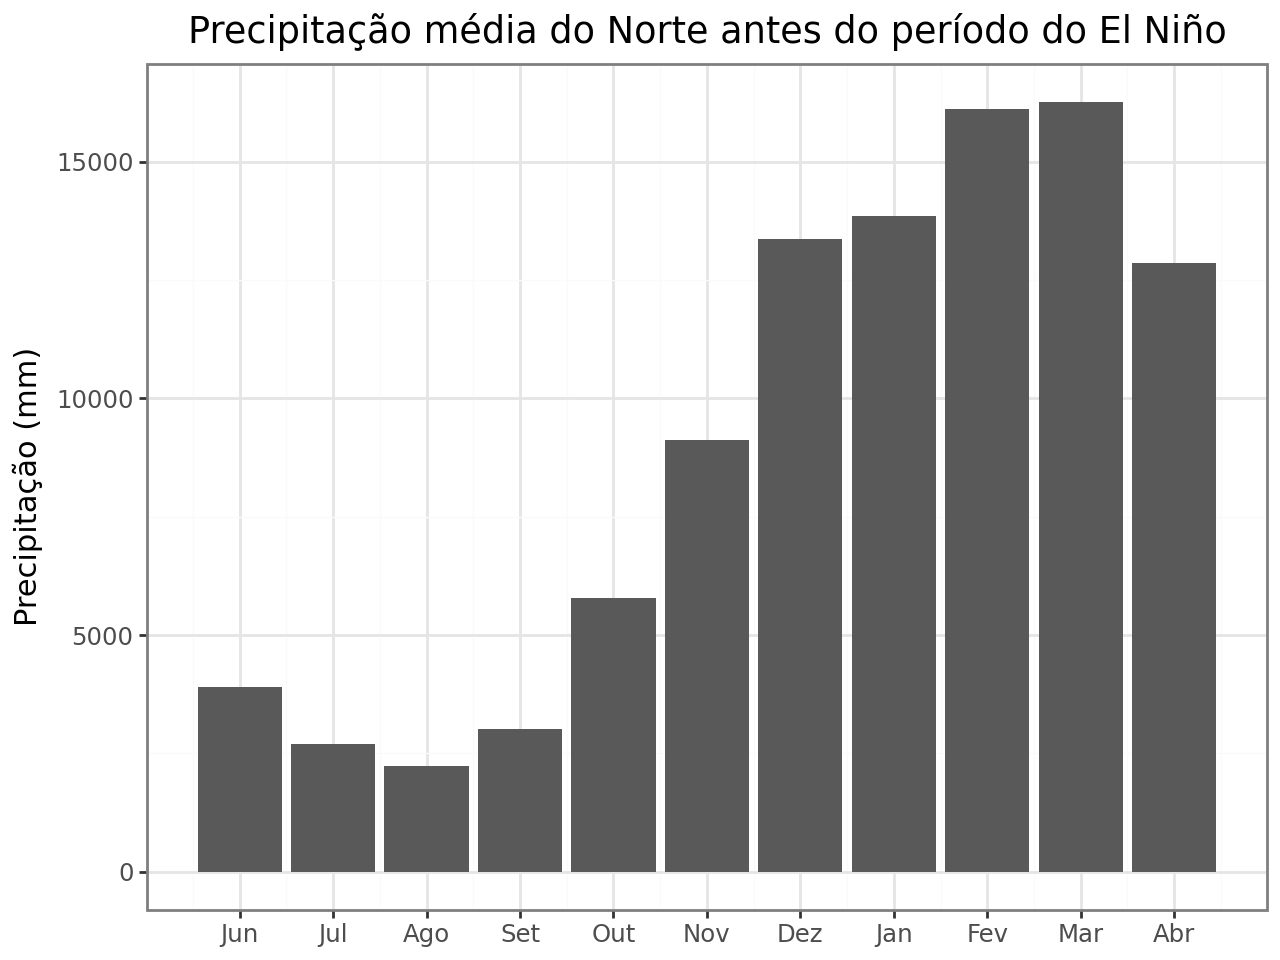

In [ ]:
# gráfico só do norte antes do el nino:
norte = dados_precipitacao.filter(pl.col("regiao") == "NORTE")
norte_sem_nino = ggplot(norte
          ) + geom_col(aes(
              x = "ordem_mes",
              y = "media_precipitacao"
          )) + scale_x_continuous(
              labels = ["Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez",
                        "Jan", "Fev", "Mar", "Abr", "Mai"],
              breaks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
          ) + labs(title = "Precipitação média do Norte antes do período do El Niño",
                   y = "Precipitação (mm)", x = ""
          ) + theme(legend_position = 'none'
          ) + theme_bw()



norte_sem_nino

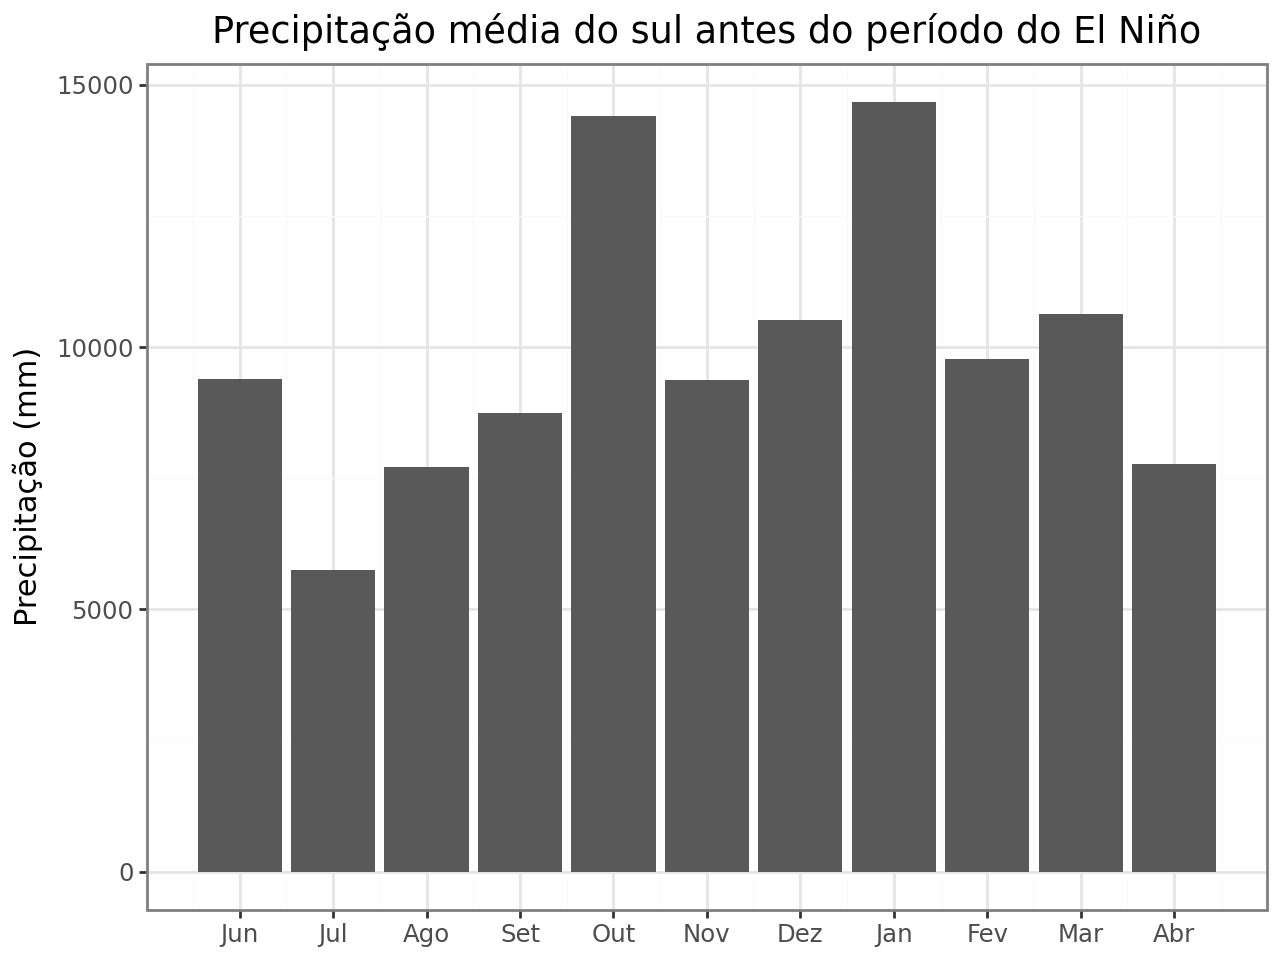

In [ ]:
# gráfico só do sul antes do el nino:
sul = dados_precipitacao.filter(pl.col("regiao") == "SUL")
sul_sem_nino = ggplot(sul
          ) + geom_col(aes(
              x = "ordem_mes",
              y = "media_precipitacao"
          )) + scale_x_continuous(
              labels = ["Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez",
                        "Jan", "Fev", "Mar", "Abr", "Mai"],
              breaks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
          ) + labs(title = "Precipitação média do sul antes do período do El Niño",
                   y = "Precipitação (mm)", x = ""
          ) + theme(legend_position = 'none'
          ) + theme_bw()



sul_sem_nino


#Visualização dos dados em Tabela

In [ ]:
tabela_diferencas = dados_precipitacao.join(
    dados_nino, on = "mes", how = "left",suffix = "_nino"
    ).filter(
        pl.col("regiao")==pl.col("regiao_nino")
        ).with_columns((pl.col("PRECIPITACAO TOTAL") - pl.col("media_precipitacao"
    )).alias("diferenca")).with_columns((pl.col("diferenca")/pl.col("media_precipitacao")*100).alias("porcentagem")).select(
        pl.col("mes"),
        pl.col("regiao"),
        pl.col("diferenca"),
        pl.col("ordem_mes"),
        pl.col("porcentagem")
        ).sort("ordem_mes")

tabela_diferencas

mes,regiao,diferenca,ordem_mes,porcentagem
i8,str,f64,i32,f64
6,"""SUL""",487.2,1,5.190599
6,"""NORDESTE""",171.27,1,3.114719
6,"""NORTE""",-104.67,1,-2.678304
7,"""NORTE""",-33.63,2,-1.243331
7,"""NORDESTE""",-1987.67,2,-38.309367
…,…,…,…,…
3,"""NORDESTE""",-945.63,10,-6.437048
3,"""NORTE""",2895.51,10,17.800897
4,"""NORDESTE""",5403.17,11,44.263498


In [ ]:
tabela_porcentagem = tabela_diferencas.select(
        pl.col("regiao"),
        pl.col("ordem_mes"),
        pl.col("porcentagem")
        )
norte_nordeste = tabela_porcentagem.filter(pl.col("regiao") != "SUL", pl.col("ordem_mes") < 8)
norte_nordeste

regiao,ordem_mes,porcentagem
str,i32,f64
"""NORDESTE""",1,3.114719
"""NORTE""",1,-2.678304
"""NORTE""",2,-1.243331
"""NORDESTE""",2,-38.309367
"""NORTE""",3,-6.180663
…,…,…
"""NORTE""",5,-27.615654
"""NORTE""",6,-32.469344
"""NORDESTE""",6,-50.65126


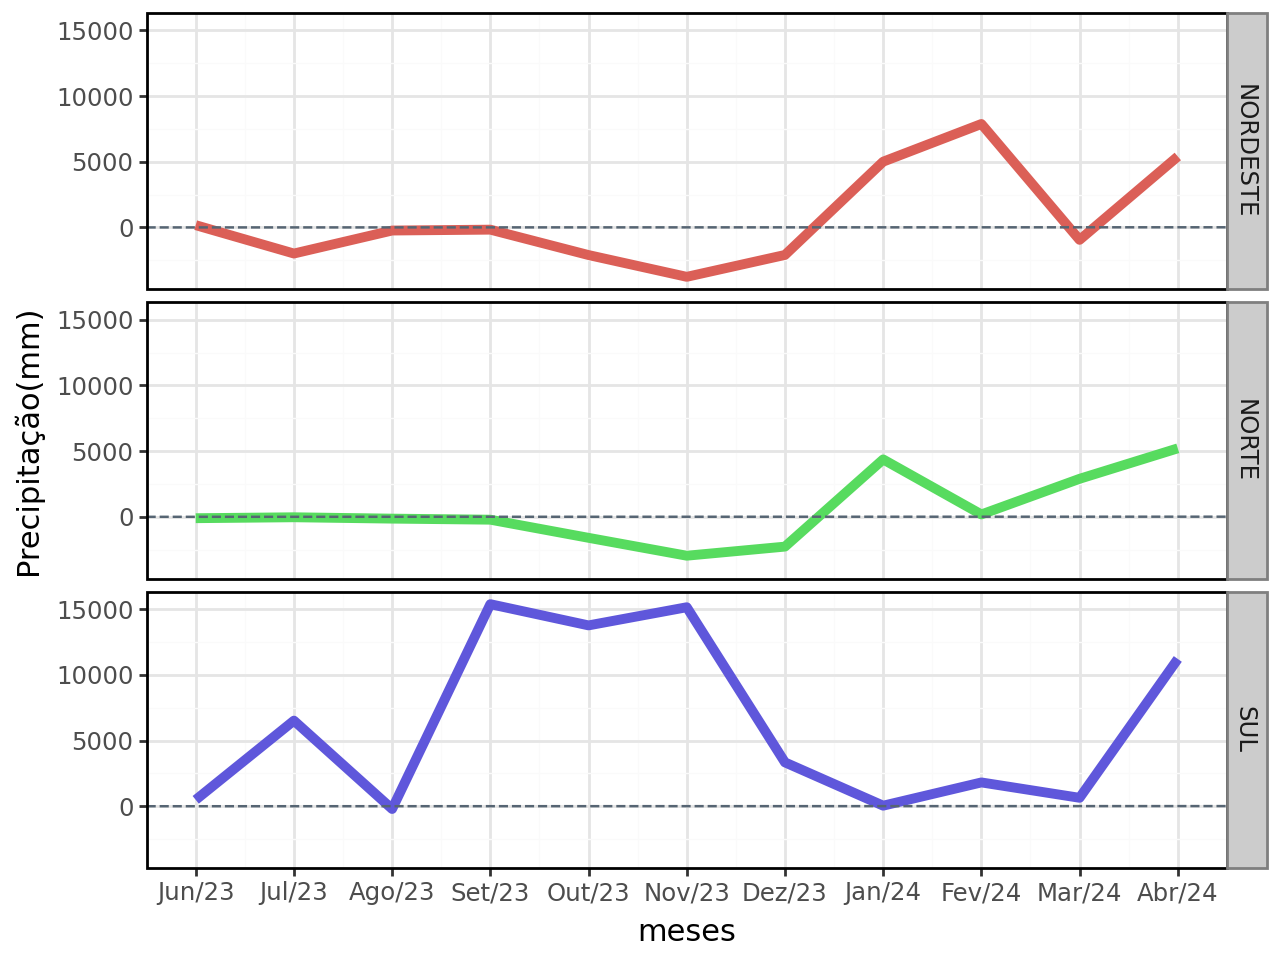

In [ ]:
grafico_diferenca = ggplot(tabela_diferencas) + geom_line(
    aes(x = "ordem_mes", y = "diferenca", color  = "regiao"
    ), size = 2) +  facet_grid("regiao"
    ) + geom_abline(color = "#566573", linetype = "dashed"
    ) + labs(
                      y = "Precipitação(mm)", x = "meses"
    ) + theme_bw() + scale_x_continuous(
        breaks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
        labels = ["Jun/23", "Jul/23", "Ago/23", "Set/23", "Out/23", "Nov/23", "Dez/23",
                        "Jan/24", "Fev/24", "Mar/24", "Abr/24"]
    ) + theme(legend_position = "none", axis_text_x=element_text(hjust=0.5),
              panel_border = element_rect(color = "black"))

grafico_diferenca

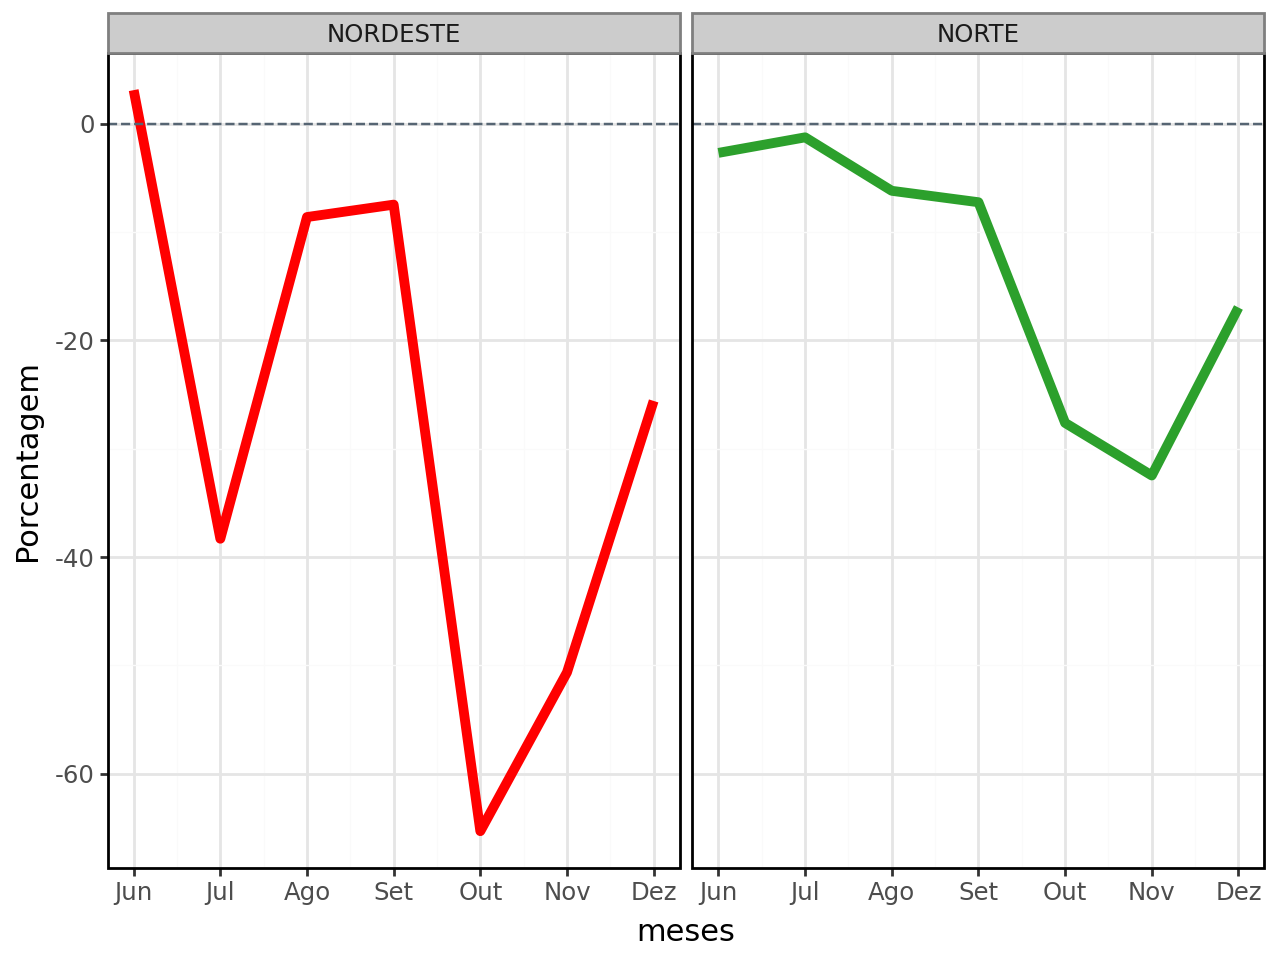

In [ ]:

grafico_porcentagem = ggplot(norte_nordeste) + geom_line(
    aes(x = "ordem_mes", y = "porcentagem", color  = "regiao"
    ), size = 2) +  facet_wrap("regiao"
    ) + geom_hline(color = "#566573", linetype = "dashed", yintercept = 0
    ) + labs(
                      y = "Porcentagem", x = "meses"
    ) + theme_bw() + scale_x_continuous(
        breaks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
        labels = ["Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez",
                        "Jan", "Fev", "Mar", "Abr"]
    ) + theme(legend_position = "none", axis_text_x=element_text(hjust=0.5),
              panel_border = element_rect(color = "black")
    ) + scale_color_manual(values = {"NORTE": 'C2', "NORDESTE": "red"})

grafico_porcentagem